In [1]:
import torch
import pandas as pd
import os
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
from timm.scheduler import CosineLRScheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import copy
import time
import os
import timm
import random
import numpy as np
import gc
import torch
import torchaudio
import torchvision
from sklearn.model_selection import StratifiedKFold
from metrics import calculate_competition_metrics, metrics_to_string, calculate_competition_metrics_no_map
from warmup_scheduler import GradualWarmupScheduler
from torch.optim import AdamW
import albumentations as A
import matplotlib.pyplot as plt
from pylab import rcParams

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse


import warnings
warnings.filterwarnings("ignore")


## Training Logs

Epoch 1 - Train loss: 0.8522, Train cmAP_1 : 0.5357, Train cmAP_5 : 0.7442, 
Epoch 1 - Valid loss: 0.8485, Valid cmAP_1 : 0.1220, Valid cmAP_5 : 0.3257, Valid mAP : 0.0082, Valid ROC : 0.5372, 
Epoch 1 - Save Best Score: 0.5372 Model

Epoch 2 - Train loss: 0.7673, Train cmAP_1 : 0.5354, Train cmAP_5 : 0.7419, 
Epoch 2 - Valid loss: 0.6464, Valid cmAP_1 : 0.1235, Valid cmAP_5 : 0.3270, Valid mAP : 0.0129, Valid ROC : 0.5611, 
Epoch 2 - Save Best Score: 0.5611 Model

Epoch 3 - Train loss: 0.3128, Train cmAP_1 : 0.5624, Train cmAP_5 : 0.7448, 
Epoch 3 - Valid loss: 0.1051, Valid cmAP_1 : 0.0590, Valid cmAP_5 : 0.2511, Valid mAP : 0.0226, Valid ROC : 0.6110, 
Epoch 3 - Save Best Score: 0.6110 Model

Epoch 4 - Train loss: 0.0411, Train cmAP_1 : 0.5409, Train cmAP_5 : 0.7417, 
Epoch 4 - Valid loss: 0.0401, Valid cmAP_1 : 0.1435, Valid cmAP_5 : 0.3504, Valid mAP : 0.0463, Valid ROC : 0.7263, 
Epoch 4 - Save Best Score: 0.7263 Model

Epoch 5 - Train loss: 0.0350, Train cmAP_1 : 0.5427, Train cmAP_5 : 0.7459, 
Epoch 5 - Valid loss: 0.0328, Valid cmAP_1 : 0.2460, Valid cmAP_5 : 0.4553, Valid mAP : 0.2485, Valid ROC : 0.8743, 
Epoch 5 - Save Best Score: 0.8743 Model

Epoch 6 - Train loss: 0.0288, Train cmAP_1 : 0.5864, Train cmAP_5 : 0.7732, 
Epoch 6 - Valid loss: 0.0261, Valid cmAP_1 : 0.3153, Valid cmAP_5 : 0.5258, Valid mAP : 0.3372, Valid ROC : 0.9202, 
Epoch 6 - Save Best Score: 0.9202 Model

Epoch 7 - Train loss: 0.0256, Train cmAP_1 : 0.5644, Train cmAP_5 : 0.7617, 
Epoch 7 - Valid loss: 0.0274, Valid cmAP_1 : 0.3493, Valid cmAP_5 : 0.5602, Valid mAP : 0.3776, Valid ROC : 0.9380, 
Epoch 7 - Save Best Score: 0.9380 Model

Epoch 8 - Train loss: 0.0236, Train cmAP_1 : 0.5792, Train cmAP_5 : 0.7725, 
Epoch 8 - Valid loss: 0.0198, Valid cmAP_1 : 0.4676, Valid cmAP_5 : 0.6471, Valid mAP : 0.5536, Valid ROC : 0.9509, 
Epoch 8 - Save Best Score: 0.9509 Model

Epoch 9 - Train loss: 0.0223, Train cmAP_1 : 0.6052, Train cmAP_5 : 0.7826, 
Epoch 9 - Valid loss: 0.0202, Valid cmAP_1 : 0.4754, Valid cmAP_5 : 0.6594, Valid mAP : 0.5519, Valid ROC : 0.9569, 
Epoch 9 - Save Best Score: 0.9569 Model

Epoch 10 - Train loss: 0.0217, Train cmAP_1 : 0.5950, Train cmAP_5 : 0.7810, 
Epoch 10 - Valid loss: 0.0198, Valid cmAP_1 : 0.4619, Valid cmAP_5 : 0.6518, Valid mAP : 0.5328, Valid ROC : 0.9592, 
Epoch 10 - Save Best Score: 0.9592 Model

Epoch 11 - Train loss: 0.0202, Train cmAP_1 : 0.6104, Train cmAP_5 : 0.7915, 
Epoch 11 - Valid loss: 0.0166, Valid cmAP_1 : 0.5612, Valid cmAP_5 : 0.7150, Valid mAP : 0.6656, Valid ROC : 0.9641, 
Epoch 11 - Save Best Score: 0.9641 Model

Epoch 12 - Train loss: 0.0197, Train cmAP_1 : 0.5942, Train cmAP_5 : 0.7841, 
Epoch 12 - Valid loss: 0.0162, Valid cmAP_1 : 0.5966, Valid cmAP_5 : 0.7349, Valid mAP : 0.6805, Valid ROC : 0.9634, 
Valid loss didn't improve last 1 epochs.

Epoch 13 - Train loss: 0.0192, Train cmAP_1 : 0.5937, Train cmAP_5 : 0.7795, 
Epoch 13 - Valid loss: 0.0159, Valid cmAP_1 : 0.6153, Valid cmAP_5 : 0.7457, Valid mAP : 0.6893, Valid ROC : 0.9669, 
Epoch 13 - Save Best Score: 0.9669 Model

Epoch 14 - Train loss: 0.0191, Train cmAP_1 : 0.5991, Train cmAP_5 : 0.7903, 
Epoch 14 - Valid loss: 0.0193, Valid cmAP_1 : 0.5310, Valid cmAP_5 : 0.7047, Valid mAP : 0.5732, Valid ROC : 0.9660, 
Valid loss didn't improve last 1 epochs.

Epoch 15 - Train loss: 0.0180, Train cmAP_1 : 0.6038, Train cmAP_5 : 0.7822, 
Epoch 15 - Valid loss: 0.0163, Valid cmAP_1 : 0.5753, Valid cmAP_5 : 0.7283, Valid mAP : 0.6613, Valid ROC : 0.9656, 
Valid loss didn't improve last 2 epochs.

Epoch 16 - Train loss: 0.0181, Train cmAP_1 : 0.6067, Train cmAP_5 : 0.7918, 
Epoch 16 - Valid loss: 0.0168, Valid cmAP_1 : 0.5555, Valid cmAP_5 : 0.7140, Valid mAP : 0.6448, Valid ROC : 0.9613, 
Valid loss didn't improve last 3 epochs.

Epoch 17 - Train loss: 0.0176, Train cmAP_1 : 0.6181, Train cmAP_5 : 0.7918, 
Epoch 17 - Valid loss: 0.0160, Valid cmAP_1 : 0.5999, Valid cmAP_5 : 0.7436, Valid mAP : 0.6738, Valid ROC : 0.9670, 
Epoch 17 - Save Best Score: 0.9670 Model

Epoch 18 - Train loss: 0.0169, Train cmAP_1 : 0.6040, Train cmAP_5 : 0.7897, 
Epoch 18 - Valid loss: 0.0174, Valid cmAP_1 : 0.5920, Valid cmAP_5 : 0.7447, Valid mAP : 0.6454, Valid ROC : 0.9690, 
Epoch 18 - Save Best Score: 0.9690 Model

Epoch 19 - Train loss: 0.0162, Train cmAP_1 : 0.6005, Train cmAP_5 : 0.7870, 
Epoch 19 - Valid loss: 0.0174, Valid cmAP_1 : 0.5855, Valid cmAP_5 : 0.7397, Valid mAP : 0.6386, Valid ROC : 0.9682, 
Valid loss didn't improve last 1 epochs.

Epoch 20 - Train loss: 0.0161, Train cmAP_1 : 0.6355, Train cmAP_5 : 0.8080, 
Epoch 20 - Valid loss: 0.0151, Valid cmAP_1 : 0.6357, Valid cmAP_5 : 0.7629, Valid mAP : 0.7092, Valid ROC : 0.9683, 
Valid loss didn't improve last 2 epochs.

Epoch 21 - Train loss: 0.0157, Train cmAP_1 : 0.6019, Train cmAP_5 : 0.7856, 
Epoch 21 - Valid loss: 0.0162, Valid cmAP_1 : 0.5980, Valid cmAP_5 : 0.7464, Valid mAP : 0.6594, Valid ROC : 0.9675, 
Valid loss didn't improve last 3 epochs.

Epoch 22 - Train loss: 0.0160, Train cmAP_1 : 0.5569, Train cmAP_5 : 0.7717, 
Epoch 22 - Valid loss: 0.0148, Valid cmAP_1 : 0.6402, Valid cmAP_5 : 0.7668, Valid mAP : 0.7204, Valid ROC : 0.9673, 
Valid loss didn't improve last 4 epochs.

Epoch 23 - Train loss: 0.0158, Train cmAP_1 : 0.6211, Train cmAP_5 : 0.8011, 
Epoch 23 - Valid loss: 0.0150, Valid cmAP_1 : 0.6254, Valid cmAP_5 : 0.7594, Valid mAP : 0.7124, Valid ROC : 0.9642, 
Valid loss didn't improve last 5 epochs.

Epoch 24 - Train loss: 0.0153, Train cmAP_1 : 0.5914, Train cmAP_5 : 0.7817, 
Epoch 24 - Valid loss: 0.0154, Valid cmAP_1 : 0.6207, Valid cmAP_5 : 0.7590, Valid mAP : 0.6824, Valid ROC : 0.9650, 
Valid loss didn't improve last 6 epochs.

Epoch 25 - Train loss: 0.0143, Train cmAP_1 : 0.6056, Train cmAP_5 : 0.7859, 
Epoch 25 - Valid loss: 0.0155, Valid cmAP_1 : 0.6094, Valid cmAP_5 : 0.7542, Valid mAP : 0.6769, Valid ROC : 0.9680, 
Valid loss didn't improve last 7 epochs.

Early stop, Training End.


In [2]:

exp_name = 'exp1
backbone = 'eca_nfnet_l0'
seed = 42
batch_size = 64
num_workers = 0

n_epochs = 100
warmup_epo = 5
cosine_epo = n_epochs - warmup_epo

image_size = 256

lr_max = 1e-5
lr_min = 1e-7
weight_decay = 1e-6

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}

top_db = 80
train_period = 5
val_period = 5

secondary_coef = 1.0

train_duration = train_period * mel_spec_params["sample_rate"]
val_duration = val_period * mel_spec_params["sample_rate"]

N_FOLD = 5
fold = 2

use_amp = True
max_grad_norm = 10
early_stopping = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_folder = "outputs"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, exp_name), exist_ok=True)



## Seed Everything

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(seed)


## Data

In [4]:
df = pd.read_csv('../data/birdclef-2024/train_metadata.csv')
df["path"] = "../data/birdclef-2024/train_audio/" + df["filename"]
df["rating"] = np.clip(df["rating"] / df["rating"].max(), 0.1, 1.0)

skf = StratifiedKFold(n_splits=N_FOLD, random_state=seed, shuffle=True)
df['fold'] = -1
for ifold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df["primary_label"].values)):
    df.loc[val_idx, 'fold'] = ifold

sub = pd.read_csv("../data/birdclef-2024/sample_submission.csv")
target_columns = sub.columns.tolist()[1:]
num_classes = len(target_columns)
bird2id = {b: i for i, b in enumerate(target_columns)}


## Dataset

In [5]:

def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V


def read_wav(path):
    wav, org_sr = torchaudio.load(path, normalize=True)
    wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"])
    return wav


def crop_start_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    wav = wav[:, :duration_]
    return wav


class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, add_secondary_labels=True):
        self.df = df
        self.bird2id = bird2id
        self.num_classes = num_classes
        self.secondary_coef = secondary_coef
        self.add_secondary_labels = add_secondary_labels
        self.mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=top_db)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def prepare_target(self, primary_label, secondary_labels):
        secondary_labels = eval(secondary_labels)
        target = np.zeros(self.num_classes, dtype=np.float32)
        if primary_label != 'nocall':
            primary_label = self.bird2id[primary_label]
            target[primary_label] = 1.0
            if self.add_secondary_labels:
                for s in secondary_labels:
                    if s != "" and s in self.bird2id.keys():
                        target[self.bird2id[s]] = self.secondary_coef
        target = torch.from_numpy(target).float()
        return target

    def prepare_spec(self, path):
        wav = read_wav(path)
        wav = crop_start_wav(wav, train_duration)
        mel_spectrogram = normalize_melspec(self.db_transform(self.mel_transform(wav)))
        mel_spectrogram = mel_spectrogram * 255
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
        return mel_spectrogram

    def __getitem__(self, idx):
        path = self.df["path"].iloc[idx]
        primary_label = self.df["primary_label"].iloc[idx]
        secondary_labels = self.df["secondary_labels"].iloc[idx]
        rating = self.df["rating"].iloc[idx]

        spec = self.prepare_spec(path)
        target = self.prepare_target(primary_label, secondary_labels)

        if self.transform is not None:
            res = self.transform(image=spec)
            spec = res['image'].astype(np.float32)
        else:
            spec = spec.astype(np.float32)

        spec = spec.transpose(2, 0, 1)

        return {"spec": spec, "target": target, 'rating': rating}


## Model

In [6]:

class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x


class CNN(torch.nn.Module):
    def __init__(self, backbone, pretrained):
        super().__init__()

        out_indices = (3, 4)
        self.backbone = timm.create_model(
            backbone,
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=num_classes,
            out_indices=out_indices,
        )
        feature_dims = self.backbone.feature_info.channels()
        print(f"feature dims: {feature_dims}")

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, num_classes)

    def forward(self, x):
        ms = self.backbone(x)
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
        return x


## Loss

In [7]:

class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss


criterion = FocalLossBCE()

## Init Utils

In [8]:
def init_logger(log_file='train.log'):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train and Val Functions

In [9]:

def mixup(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)])
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)

    return data, targets

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    losses = AverageMeter()
    gt = []
    preds = []
    bar = tqdm(loader, total=len(loader))
    for batch in bar:
        optimizer.zero_grad()
        spec = batch['spec']
        target = batch['target']

        spec, target = mixup(spec, target, 0.5)

        spec = spec.to(device)
        target = target.to(device)

        if scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(spec)
                loss = criterion(logits, target)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(spec)
            loss = criterion(logits, target)
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

        losses.update(loss.item(), batch["spec"].size(0))
        bar.set_postfix(
            loss=losses.avg,
            grad=grad_norm.item(),
            lr=optimizer.param_groups[0]["lr"]
        )
        gt.append(target.cpu().detach().numpy())
        preds.append(logits.sigmoid().cpu().detach().numpy())
    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
    scores = calculate_competition_metrics_no_map(gt, preds, target_columns)

    return scores, losses.avg


def valid_one_epoch(model, loader):
    model.eval()
    losses = AverageMeter()
    bar = tqdm(loader, total=len(loader))
    gt = []
    preds = []

    with torch.no_grad():
        for batch in bar:
            spec = batch['spec'].to(device)
            target = batch['target'].to(device)

            logits = model(spec)
            loss = criterion(logits, target)

            losses.update(loss.item(), batch["spec"].size(0))

            gt.append(target.cpu().detach().numpy())
            preds.append(logits.sigmoid().cpu().detach().numpy())

            bar.set_postfix(loss=losses.avg)

    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
    scores = calculate_competition_metrics(gt, preds, target_columns)
    return scores, losses.avg



## Scheduler

In [11]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

## Transformation Images

In [ ]:

transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(image_size, image_size),
    A.CoarseDropout(max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), max_holes=1, p=0.7),
    A.Normalize()
])

transforms_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

## Scheduler Plot

feature dims: [1536, 2304]


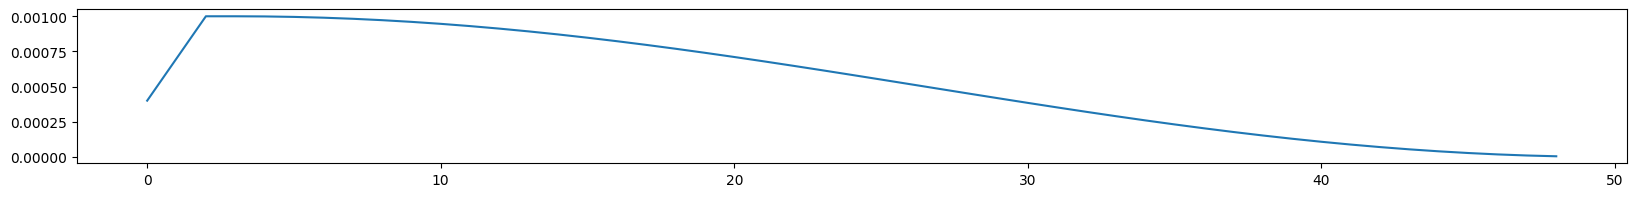

In [12]:
model = CNN(backbone=backbone, pretrained=False)
rcParams['figure.figsize'] = 20, 2

optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

lrs = []
for epoch in range(1, n_epochs):
    scheduler_warmup.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(range(len(lrs)), lrs)

In [13]:

def train_fold():
    logger = init_logger(log_file=os.path.join(output_folder, exp_name, f"{fold}.log"))

    logger.info("=" * 90)
    logger.info(f"Fold {fold} Training")
    logger.info("=" * 90)

    trn_df = df[df['fold'] != fold].reset_index(drop=True)
    val_df = df[df['fold'] == fold].reset_index(drop=True)
    print(trn_df.shape)
    logger.info(trn_df.shape)
    logger.info(trn_df['primary_label'].value_counts())
    logger.info(val_df.shape)
    logger.info(val_df['primary_label'].value_counts())


    trn_dataset = BirdDataset(df=trn_df.reset_index(drop=True), transform=transforms_train, add_secondary_labels=True)
    v_ds = BirdDataset(df=val_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True)


    train_loader = torch.utils.data.DataLoader(trn_dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(v_ds, shuffle=False, batch_size=batch_size, drop_last=False, num_workers=num_workers, pin_memory=True)


    model = CNN(backbone=backbone, pretrained=True).to(device)
    optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)


    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    patience = early_stopping
    best_score = 0.0
    n_patience = 0

    for epoch in range(1, n_epochs + 1):
        print(time.ctime(), 'Epoch:', epoch)

        scheduler_warmup.step(epoch-1)

        train_scores, train_losses_avg = train_one_epoch(model, train_loader, optimizer, scaler)
        train_scores_str = metrics_to_string(train_scores, "Train")
        train_info = f"Epoch {epoch} - Train loss: {train_losses_avg:.4f}, {train_scores_str}"
        logger.info(train_info)

        val_scores, val_losses_avg = valid_one_epoch(model, val_loader)
        val_scores_str = metrics_to_string(val_scores, f"Valid")
        val_info = f"Epoch {epoch} - Valid loss: {val_losses_avg:.4f}, {val_scores_str}"
        logger.info(val_info)

        val_score = val_scores["ROC"]

        is_better = val_score > best_score
        best_score = max(val_score, best_score)

        if is_better:
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            logger.info(
                f"Epoch {epoch} - Save Best Score: {best_score:.4f} Model\n")
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"{fold}.bin")
            )
            n_patience = 0
        else:
            n_patience += 1
            logger.info(
                f"Valid loss didn't improve last {n_patience} epochs.\n")

        if n_patience >= patience:
            logger.info(
                "Early stop, Training End.\n")
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"final_{fold}.bin")
            )
            break

    del model
    torch.cuda.empty_cache()
    gc.collect()


Fold 4 Training


(19568, 14)

primary_label

zitcis1    400

lirplo     400

litgre1    400

comgre     400

comkin1    400

          ... 

blaeag1      5

bncwoo3      5

asiope1      4

integr       4

niwpig1      4

Name: count, Length: 182, dtype: int64

(4891, 14)

primary_label

zitcis1    100

lirplo     100

comgre     100

comkin1    100

commoo3    100

          ... 

asiope1      1

integr       1

blaeag1      1

rutfly6      1

niwpig1      1

Name: count, Length: 182, dtype: int64


(19568, 14)


In [ ]:
train_fold()